In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubhamkashid123","key":"5aa9c347ba2a8783ea0b5ef3582901f6"}'}

In [2]:
import os
import shutil

os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 600)


In [3]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
100% 1.06G/1.06G [00:05<00:00, 188MB/s]
100% 1.06G/1.06G [00:05<00:00, 208MB/s]


In [4]:
!unzip dogs-vs-cats.zip -d dogs-vs-cats

Streaming output truncated to the last 5000 lines.
  inflating: dogs-vs-cats/train/dogs/dog.4419.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.442.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4420.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4421.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4422.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4424.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4425.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4426.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4427.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4431.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4433.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4436.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4438.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4439.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.444.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4440.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4441.jpg  
  inflating: dogs-vs-cats/train/dogs/dog.4442.jpg  
  inflating: do

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.models import Sequential as sequential

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   41G   73G  36% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  775M  61% /usr/sbin/docker-init
/dev/sda1        74G   42G   32G  58% /kaggle/input
tmpfs           6.4G   68K  6.4G   1% /var/colab
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [8]:
#generators

train_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/dogs-vs-cats/train",
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (256,256)
)


validation_ds = keras.utils.image_dataset_from_directory(
    directory = "/content/dogs-vs-cats/test",
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [9]:
#normalisation

def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [10]:
#create cnn model

cnn = sequential()

In [11]:
cnn.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn.add(Flatten())

cnn.add(Dense(128,activation='relu',kernel_regularizer=l2(l2=0.001)))
cnn.add(Dropout(0.1))
cnn.add(Dense(64,activation='relu',kernel_regularizer=l2(l2=0.001)))
cnn.add(Dropout(0.1))
cnn.add(Dense(32,activation='relu',kernel_regularizer=l2(l2=0.001)))
cnn.add(Dropout(0.1))
cnn.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,241 (56.65 MB)

 Trainable params: 14,849,793 (56.65 MB)

 Non-trainable params: 448 (1.75 KB)

In [13]:
#compile
cnn.compile(optimizer = "adam",loss = "binary_crossentropy",metrics=["accuracy"])

In [14]:
history = cnn.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 64s 82ms/step - accuracy: 0.5531 - loss: 2.7907 - val_accuracy: 0.5916 - val_loss: 1.1563
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step - accuracy: 0.6566 - loss: 1.0407 - val_accuracy: 0.7342 - val_loss: 0.8787
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.7457 - loss: 0.8308 - val_accuracy: 0.7470 - val_loss: 0.8126
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.7816 - loss: 0.7547 - val_accuracy: 0.7618 - val_loss: 0.7819
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 84ms/step - accuracy: 0.8029 - loss: 0.7320 - val_accuracy: 0.7686 - val_loss: 0.7868
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8256 - loss: 0.7207 - val_accuracy: 0.8012 - val_loss: 0.7849
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.8423 - loss: 0.7494 - val_accuracy: 0.7724 - val_loss: 1.2026
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 48s 77ms/step - accuracy: 0.8616 - loss: 0.8521 - 

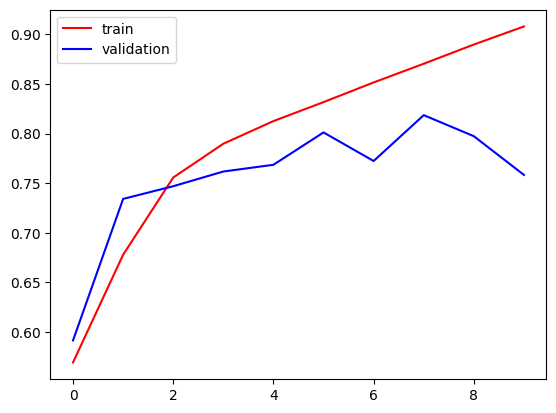

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],color="red",label="train")
plt.plot(history.history["val_accuracy"],color="blue",label="validation")
plt.legend()
plt.show()

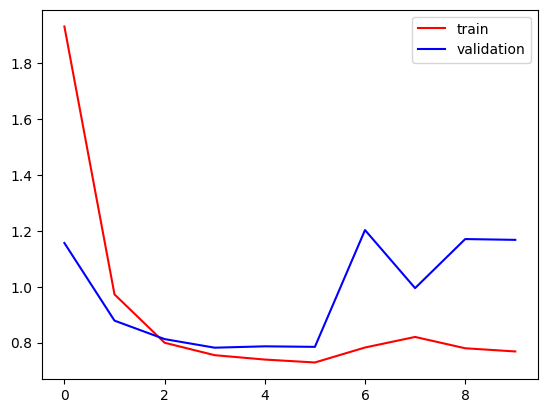

In [16]:
plt.plot(history.history["loss"],color="red",label="train")
plt.plot(history.history["val_loss"],color="blue",label="validation")
plt.legend()
plt.show()

In [17]:
#TRY TO IMPROVING AGAIN

In [ ]:
# === Imports === #
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Data Augmentation & Loading === #
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_ds = train_datagen.flow_from_directory(
    "/content/dogs-vs-cats/train",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

validation_ds = val_datagen.flow_from_directory(
    "/content/dogs-vs-cats/test",
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary'
)

# === Compute Class Weights === #
labels = train_ds.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

# === Load Pretrained Base === #
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

# === Custom Classification Head === #
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# === Compile Model === #
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# === Callbacks === #
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# === Train Model === #
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)




Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


/tmp/ipython-input-18-3524424843.py:49: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 352s 544ms/step - accuracy: 0.8969 - loss: 0.2563 - val_accuracy: 0.9752 - val_loss: 0.0728 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 328s 525ms/step - accuracy: 0.9764 - loss: 0.0711 - val_accuracy: 0.9784 - val_loss: 0.0572 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 390s 538ms/step - accuracy: 0.9776 - loss: 0.0613 - val_accuracy: 0.9800 - val_loss: 0.0525 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 520ms/step - accuracy: 0.9806 - loss: 0.0548 - val_accuracy: 0.9810 - val_loss: 0.0500 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 325s 519ms/step - accuracy: 0.9825 - loss: 0.0488 - val_accuracy: 0.9828 - val_loss: 0.0492 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 329s 526ms/step - accuracy: 0.9829 - loss: 0.0482 - val_accuracy: 0.9818 - val_loss: 0.0516 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 

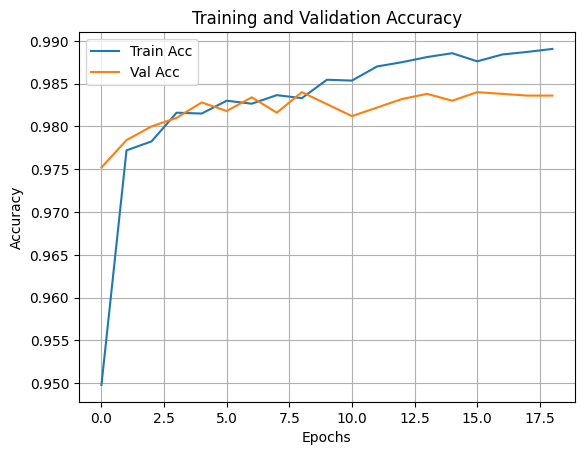

In [22]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

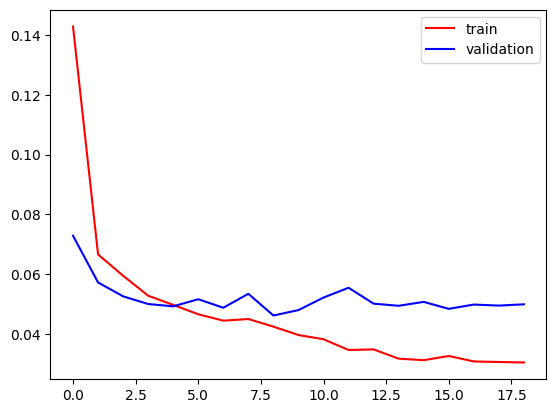

In [23]:
plt.plot(history.history["loss"],color="red",label="train")
plt.plot(history.history["val_loss"],color="blue",label="validation")
plt.legend()
plt.show()

In [30]:
model.save("mobilenetv2_binary_classifier.h5")




In [54]:
import os

# Check if file exists in current directory
print(os.path.exists("mobilenetv2_binary_classifier.h5"))


True


Saving Screenshot 2025-07-20 174402.png to Screenshot 2025-07-20 174402 (1).png


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


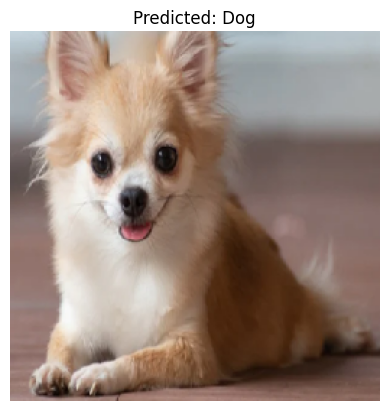

In [53]:
from google.colab import files
uploaded = files.upload()
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load model
model = load_model('mobilenetv2_binary_classifier.h5')

# Get the uploaded filename
img_path = list(uploaded.keys())[0]

# Preprocess
img = image.load_img(img_path, target_size=(256, 256))
x = image.img_to_array(img) / 255.0
x = np.expand_dims(x, axis=0)

# Predict
pred = model.predict(x)[0][0]
label = "Dog" if pred >= 0.5 else "Cat"

# Show result
plt.imshow(img)
plt.title(f"Predicted: {label}")
plt.axis('off')
plt.show()


In [55]:
from google.colab import files
files.download("mobilenetv2_binary_classifier.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>